<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea17_electrical_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from scipy import stats

In [3]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'
df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = serie.ravel() ## Con esto quitamos el bracket o corchete en cada uno de loselementos del arreglo

## Una red de juguete con Networkx

In [4]:
## https://github.com/urieliram/statistical/blob/main/Tarea13.ipynb
#serie = [1,1,7,7,9,8,1,8,7,0,2,7,6,1,1,6,6,5,9,2,7,9,0,1,2,9,7,9,2,0,7,5,5,5,5,7,9
#,9,0,7,5,5,6,0,4,3,5,5,3,5,0,2,0,5,0,5,6,4,3,4,9,2,6,2,8,0,4,7,6,5,2,0,3,2
#,3,0,6,2,6,6,4,5,0,6,1,4,9,6,0,3,6,9,5,0,2,4,3,5,0,5,6,4,5,5,0,3,2,0,2,1,7
#,3,3,2,5,3,5,7,5,1,3,5,9,4,6,6,5,2,0,4,0,5,0,7,2,1,5,9,5,7,4,0,3,4,5,4,0,5
#,2,2,5,4,9,7,6,0,5,5,5,5,0,0,3,5,2,2,3,9,5,7,5,3,5,9,5,4,0,2,4,4,6,1,0,5,0
#,5,0,7,0,0,0,0,2,4,4,3,0,4,3,0,2,6,0,6,5,2,6,5,0,5,5,0,2,2,5,2,4,9,0,2,5,6
#,1,0,0,0,5,8,0,5,3,0,0,3,5,0,0,2,5,2,7,2,5,0,4,5,6,9,0,5,4,0]

serie = [1,1,7,7,9,8,1,8,7,0,2,7,6,1,1,6,6,5,9,2,7,9,0,1,2,9,7,9,2,0,7,5,5,5,5,7,
         9,9,0,7,5,5,6,0,4,3,5,5,5,5,0,2,0,5,5,5,6,4,3,4,9,2,6,2,8,0,4,7,6,5,2,0,
         3,2,0,0,6,2,6,6,4,5,0,6,1,4,9,6,0,3,6,9,5,0,2,4,3,5,0,5,6,4,5,5,0,3,2,0,
         2,1,7,3,5,2,5,3,5,6,5,1,3,5,9,4,6,6,5,2,0,4,0,5,0,7,2,1,5,9,5,7,3,0,3,4,
         5,3,0,5,2,2,5,4,9,7,6,0,5,5,5,5,0,0,3,5,2,5,3,9,5,7,5,3,5,9,5,4,0,2,4,4,
         6,1,0,5,0,5,0,7,0,0,0,0,2,4,4,3,0,4,3,0,2,6,0,6,5,2,6,5,0,5,5,0,2,2,5,2,
         4,9,0,2,5,6,1,0,0,0,5,8,0,5,3,0,0,3,5,0,0,5,5,5,7,2,5,0,4,5,6,0,0,5,4,0]


In [5]:
nodes = np.unique(serie)
n = len(nodes)
A = np.zeros(shape=(n,n))

In [6]:
for i in range(len(serie)-1):
    A[serie[i],serie[i+1]] = A[serie[i],serie[i+1]] + 1
A

array([[10.,  1.,  9.,  6.,  5., 12.,  3.,  4.,  0.,  0.],
       [ 2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  0.],
       [ 6.,  2.,  2.,  0.,  4.,  6.,  4.,  2.,  1.,  1.],
       [ 5.,  0.,  2.,  0.,  2.,  8.,  1.,  0.,  0.,  1.],
       [ 3.,  0.,  0.,  5.,  2.,  4.,  2.,  1.,  0.,  4.],
       [13.,  1.,  7.,  5.,  3., 16.,  6.,  4.,  1.,  4.],
       [ 5.,  4.,  2.,  0.,  3.,  6.,  3.,  0.,  0.,  1.],
       [ 2.,  0.,  2.,  2.,  0.,  3.,  3.,  1.,  0.,  4.],
       [ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 3.,  0.,  3.,  0.,  1.,  4.,  1.,  2.,  1.,  1.]])

In [7]:
#G = nx.Graph()
G = nx.DiGraph()
G.add_nodes_from(nodes)

In [10]:
rows = A.shape[0]
cols = A.shape[1]
for i in range(0, cols - 1):
    for j in range(0, rows -1):
        if A[i,j] != 0:
            G.add_edge(i, j)
            G.edges[i, j]['color'] = "red"


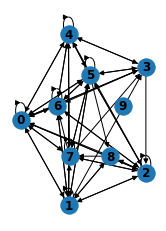

In [11]:
subax1 = plt.subplot(121)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

[Creating a graph Networkx](https://networkx.org/documentation/stable/tutorial.html)

[Drawing graphs Networkx](https://networkx.org/documentation/stable/tutorial.html#drawing-graphs)

[A study of visibility graphs for time series representations](https://upcommons.upc.edu/bitstream/handle/2117/328691/152711.pdf?sequence=1&isAllowed=y)

## Una red con Pandapower

Ramas
0.   Número de la rama.
1.   Nombre completo de la rama.
2.   Índice del nodo origen.
3.   Nombre del nodo origen.
4.   Índice del nodo destino.
5.   Nombre del nodo destino.
6.   Resistencia de la rama en pu.
7.   Reactancia de la rama en pu.
8.   Disponibilidad inicial de la rama.
9.   Tipos de rama (1: línea, 2: transformador).

Nodos
0.   Número de bus.
1.   Nombre completo del bus.
2.   Nombre abreviado del bus.
3.   Número del área.
4.   Nombre del área completo.
5.   Nombre del área abreviado.
6.   Tensión nominal (KV). (F
7.   Subsistema eléctrico.
8.   Nombre completo de región de precios.
9.   Nombre abreviado de región de precios.
10.  Número de la región de precios.
11.  Disponibilidad inicial del nodo.

In [33]:
path      = 'https://drive.google.com/uc?export=download&id=' 
URL_Nodos = 'https://drive.google.com/file/d/1EGZ5pJXmfGs74T6yIxf73Cse9tV-w_UM/view?usp=sharing'
URL_Ramas = 'https://drive.google.com/file/d/1Bk09OWzfNFGxzINbCKfPOkqcu6ESFdwZ/view?usp=sharing'
df_Nodos  = pd.read_csv(path+URL_Nodos.split('/')[-2],usecols=[0,1,2,3,4,5,6,7,8,9,10,11],names=['No','Name','Avr','Region','Place','Place2','KV','Sub','Prices','Prices2','Price3','Avail'])
df_Nodos.dropna(inplace=True)
nodos = df_Nodos.to_numpy()
#nodos = nodos.ravel() ## Con esto quitamos el bracket o corchete en cada uno de los elementos del arreglo
df_Ramas  = pd.read_csv(path+URL_Ramas.split('/')[-2],usecols=[0,1,2,3,4,5,6,7,8,9],names=['No','Name','Orig','NameOrig','Destino','NameDest','R','X','Type','Avail'])
df_Ramas.dropna(inplace=True)
ramas = df_Ramas.to_numpy()
#ramas = ramas.ravel() ## Con esto quitamos el bracket o corchete en cada uno de los elementos del arreglo

display(ramas)

array([[1, '05JOM   A3A20   05TRS', 135, ..., 0.05095, 1, 1],
       [2, '05MVI   A3A40   05TRS', 6042, ..., 0.00563, 1, 1],
       [3, 'AND-230-GPL-230_02', 2, ..., 0.0234, 1, 1],
       ...,
       [8520, 'STO-115-STO-U2_02', 6506, ..., 0.816, 2, 1],
       [8521, 'ENA-115-ENA-13.A_01', 6472, ..., 0.01632, 2, 1],
       [8522, 'VCG-115-VCG-34.5_01', 6520, ..., 0.08222, 2, 1]],
      dtype=object)